# <center>German real estate apartment listings over time</center>


## 0) Imports

In [20]:
import concurrent.futures
import time
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob

%load_ext nb_black
%matplotlib inline

plt.rcParams["figure.dpi"] = 130
pd.set_option("display.precision", 2)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## 1) Data Engineering

### 1.0) Helper functions:

In [2]:
def load_df(filepath):
    df = pd.read_csv(filepath, sep=";", low_memory=False)
    df.columns = [
        x.replace("obj_", "").replace("ga_", "").replace("geo_", "") for x in df.columns
    ]
    df = df.drop_duplicates(subset="scoutId")
    df = df[df.columns[~df.isnull().any()]]
    return df


def create_rent_df(date):
    rent_filepath = "../data/mieten" + date + ".csv"
    rent_df = load_df(rent_filepath)
    rent_df["rent_m2"] = rent_df["baseRent"] / rent_df["livingSpace"]
    return rent_df


def create_sale_df(date):
    sale_filepath = "../data/kaufen" + date + ".csv"
    sale_df = load_df(sale_filepath)
    sale_df["price_m2"] = sale_df["purchasePrice"] / sale_df["livingSpace"]
    return sale_df


def create_combined_df(date):
    rent_df = create_rent_df(date)
    sale_df = create_sale_df(date)
    g = rent_df.groupby("zipCode")["rent_m2"].median()
    g.name = "rent_m2_zipCode"
    sale_df = sale_df.join(g, on="zipCode").copy()
    sale_df["yearly_ROI"] = sale_df["rent_m2_zipCode"] * 12 / sale_df["price_m2"]

    group = "zipCode"
    combined_df = pd.concat(
        [
            sale_df.groupby(group)["yearly_ROI"].median(),
            rent_df.groupby(group)["rent_m2"].median(),
            rent_df.groupby(group)["rent_m2"].size(),
            sale_df.groupby(group)["price_m2"].median(),
            sale_df.groupby(group)["price_m2"].size(),
        ],
        axis=1,
        keys=[
            "median_yearly_ROI " + date,
            "median_rent_m2 " + date,
            "num_rent " + date,
            "median_price_m2 " + date,
            "num_sale " + date,
        ],
    ).copy()
    return combined_df


def compute_change(df_column, startdate, enddate):
    return time_df[df_column + enddate] / time_df[df_column + startdate]

<IPython.core.display.Javascript object>

### 1.1) Data processing:

#### find dates:

In [3]:
dates = sorted(
    [
        s[s.find("mieten") + len("mieten") : s.rfind(".csv")]
        for s in glob.glob("../data/mieten*")
    ]
)

<IPython.core.display.Javascript object>

#### create time series dataframe with multithreading:

In [4]:
start = time.perf_counter()
with concurrent.futures.ThreadPoolExecutor() as executor:
    combined_dfs = executor.map(create_combined_df, dates)

time_df = pd.concat(combined_dfs, axis=1)
time_df = time_df.replace([np.inf, -np.inf], np.nan)
time_df = time_df.dropna()

finish = time.perf_counter()
print(f"Finished in {round(finish-start, 2)} seconds")

Finished in 21.38 seconds


<IPython.core.display.Javascript object>

#### add columns for change:

In [5]:
startdate = dates[0]
enddate = dates[-1]
time_df["median_yearly_ROI change"] = compute_change(
    "median_yearly_ROI ", startdate, enddate
)
time_df["median_rent_m2 change"] = compute_change("median_rent_m2 ", startdate, enddate)
time_df["num_rent change"] = compute_change("num_rent ", startdate, enddate)
time_df["median_price_m2 change"] = compute_change(
    "median_price_m2 ", startdate, enddate
)
time_df["num_sale change"] = compute_change("num_sale ", startdate, enddate)


move_cols = [
    "median_yearly_ROI change",
    "median_rent_m2 change",
    "num_rent change",
    "median_price_m2 change",
    "num_sale change",
]
time_df = time_df[move_cols + [col for col in time_df.columns if col not in move_cols]]

<IPython.core.display.Javascript object>

## 2) Results

### 2.0) helper functions

In [15]:
def plot_1feature(attr, dates, feature1):
    x = dates
    y1 = [time_df.loc[attr][f"{feature1} {date}"] for date in x]
    color1 = "orange"

    fig, ax1 = plt.subplots()
    fig.suptitle(f"{feature1} in {attr}")

    ax1.set_xlabel("date")
    ax1.set_ylabel(feature1, color=color1)
    ax1.plot(x, y1, color=color1, label=feature1)
    ax1.set_xticklabels(x, rotation=90)

    ax1.legend()
    plt.show()


def plot_2features(rentsale_type, attr, dates, feature1, feature2):
    x = dates
    y1 = [time_df.loc[attr][f"{feature1} {date}"] for date in x]
    y2 = [time_df.loc[attr][f"{feature2} {date}"] for date in x]
    color1 = "blue"
    color2 = "green"

    fig, ax1 = plt.subplots()
    fig.suptitle(f"Apartments for {rentsale_type} in {attr}")

    ax1.set_xlabel("date")
    ax1.set_ylabel(feature1, color=color1)
    ax1.plot(x, y1, color=color1, label=feature1)
    ax1.set_xticklabels(x, rotation=90)

    ax2 = ax1.twinx()
    ax2.set_ylabel(feature2, color=color2)
    ax2.plot(x, y2, linestyle="--", color=color2, label=feature2)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2)
    plt.show()

<IPython.core.display.Javascript object>

### 2.1) Overview

In [16]:
min_num = 5
startdate = dates[0]
enddate = dates[-1]
time_ord = "median_yearly_ROI change"

time_filt = (
    (time_df["num_rent " + startdate] > min_num)
    & (time_df["num_rent " + startdate] > min_num)
    & (time_df["num_sale " + enddate] > min_num)
    & (time_df["num_sale " + enddate] > min_num)
)

time_df[time_filt].sort_values(time_ord, ascending=False)

,median_yearly_ROI change,median_rent_m2 change,num_rent change,median_price_m2 change,num_sale change,median_yearly_ROI 2020-04-04,median_rent_m2 2020-04-04,num_rent 2020-04-04,median_price_m2 2020-04-04,num_sale 2020-04-04,...,median_yearly_ROI 2020-04-25,median_rent_m2 2020-04-25,num_rent 2020-04-25,median_price_m2 2020-04-25,num_sale 2020-04-25,median_yearly_ROI 2020-04-28,median_rent_m2 2020-04-28,num_rent 2020-04-28,median_price_m2 2020-04-28,num_sale 2020-04-28
zipCode,,,,,,,,,,,,,,,,,,,,,
9120,2.20,0.97,1.00,0.44,0.58,0.02,5.23,162.0,3043.79,12.0,...,0.05,5.10,160.0,1348.31,7.0,0.05,5.10,162.0,1348.31,7.0
45472,2.14,1.13,1.32,0.53,1.56,0.03,7.50,19.0,3559.52,9.0,...,0.05,8.50,23.0,1973.68,15.0,0.05,8.50,25.0,1884.99,14.0
80937,2.06,1.90,0.71,0.92,1.00,0.02,12.79,7.0,8328.18,6.0,...,0.04,24.29,5.0,7672.31,6.0,0.04,24.29,5.0,7672.31,6.0
26382,2.04,0.99,1.06,0.49,0.90,0.02,5.83,35.0,3009.65,20.0,...,0.04,5.69,43.0,1527.85,20.0,0.05,5.76,37.0,1460.70,18.0
59423,1.79,1.22,0.71,0.68,1.80,0.02,5.74,14.0,2773.89,5.0,...,0.04,6.27,11.0,1893.32,9.0,0.04,7.01,10.0,1893.32,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47475,0.53,0.87,1.12,1.64,1.50,0.08,8.10,34.0,1175.94,6.0,...,0.04,7.01,39.0,1934.41,9.0,0.04,7.03,38.0,1934.41,9.0
58300,0.52,1.02,1.14,1.95,6.00,0.06,6.30,28.0,1291.98,2.0,...,0.03,6.49,34.0,2648.15,7.0,0.03,6.42,32.0,2521.19,12.0
24944,0.52,0.88,1.06,1.67,0.90,0.05,9.75,31.0,2266.67,10.0,...,0.03,8.83,34.0,3787.12,9.0,0.03,8.62,33.0,3787.12,9.0


<IPython.core.display.Javascript object>

### 2.2) Apartments for rent

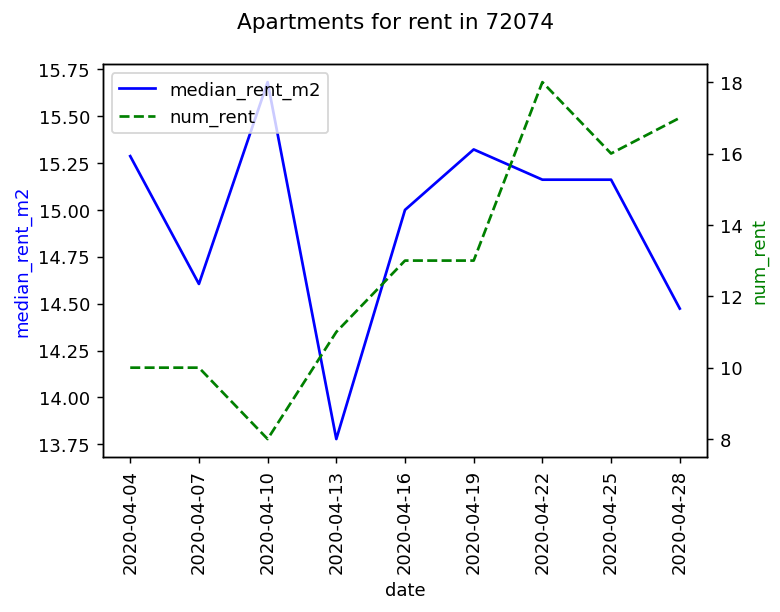

<IPython.core.display.Javascript object>

In [17]:
group_attributes = [72074]
feature1 = "median_rent_m2"
feature2 = "num_rent"

for attr in group_attributes:
    plot_2features("rent", attr, dates, feature1, feature2)

### 2.3) Apartments for sale

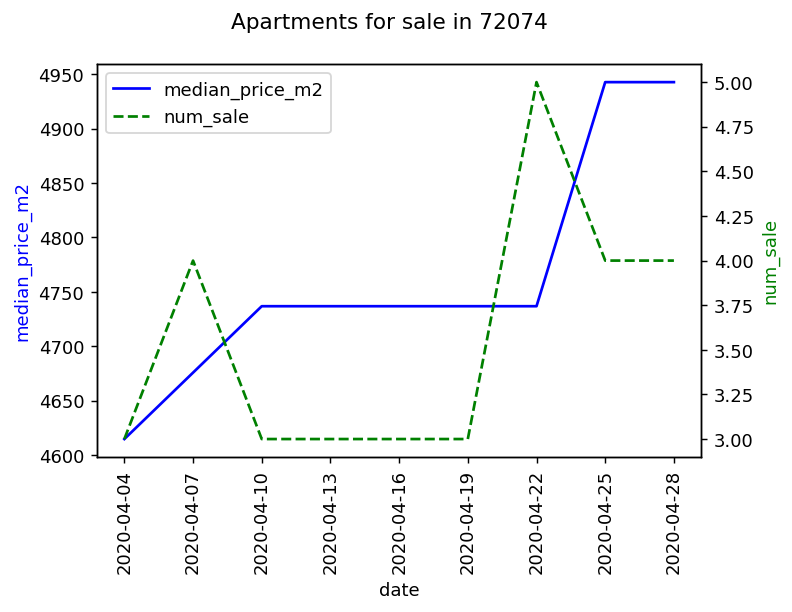

<IPython.core.display.Javascript object>

In [18]:
group_attributes = [72074]
feature1 = "median_price_m2"
feature2 = "num_sale"

for attr in group_attributes:
    plot_2features("sale", attr, dates, feature1, feature2)

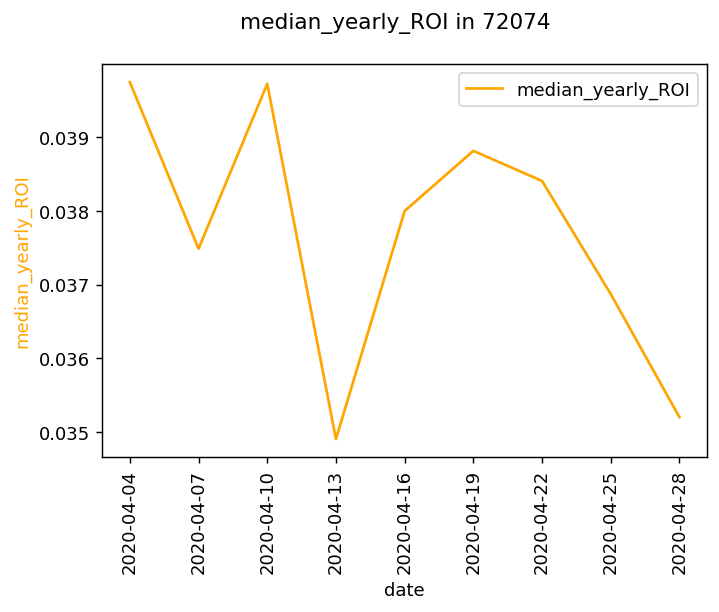

<IPython.core.display.Javascript object>

In [19]:
group_attributes = [72074]
feature1 = "median_yearly_ROI"

for attr in group_attributes:
    plot_1feature(attr, dates, feature1)